In [2]:
%autoreload 2

In [3]:
from argparse import Namespace
from collections import defaultdict, Counter
import copy
from datetime import datetime
import gzip
import itertools
import os
import pickle
import re
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams as nltk_ngrams
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src.room_and_object_types import CATEGORIES_TO_TYPES, EMPTY_OBJECT
from src.fitness_features import COMMON_SENSE_PREDICATES_FUNCTIONS, PREDICATE_FUNCTION_ARITY_MAP
from src import ast_printer

In [8]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [16]:
whitespace_pattern = re.compile(r'\s+')
variable_pattern = re.compile(r'\?[A-Za-z0-9_]+')
preference_name_pattern = re.compile(r'\(preference\s+([A-Za-z0-9_]+)\s+')
number_and_decimal_pattern = re.compile(r'\-?[0-9]+(\.[0-9]+)?')
non_token_characters = re.compile(r'\(|\)|\:|\-')


def ngram_preprocess(game_text: str):
    # remove game preamble
    domain_start = game_text.find('(:domain')
    domain_end = game_text.find(')', domain_start)
    game_text = game_text[domain_end + 1:]
    # remove variables
    game_text = variable_pattern.sub('', game_text)
    # replace preference names
    for preference_name in preference_name_pattern.findall(game_text):
        game_text = game_text.replace(preference_name, 'preferenceName')
    # remove numbers and decimals
    game_text = number_and_decimal_pattern.sub('number', game_text)
    # remove non-token characters
    game_text = non_token_characters.sub('', game_text)
    # standardize whitespace
    game_text = whitespace_pattern.sub(' ', game_text)

    return game_text.strip()


def _ngrams(text: str, n: int) -> typing.Iterable[typing.Tuple[str, ...]]:
    return nltk_ngrams(ngram_preprocess(text).split(), n)


def compute_ngram_counts(texts: typing.Sequence[str], n: int) -> typing.Dict[typing.Tuple[str], int]:
    return Counter(itertools.chain.from_iterable(_ngrams(text, n) for text in texts))


class NGramModel:
    def __init__(self, n: int, default_logprob: float = 1e-5):
        self.n = n
        self.default_logprob = default_logprob
        self.k = None
        self.top_k_ngrams = None

    def _default_logprob(self):
        return self.default_logprob

    def fit(self, game_texts: typing.Sequence[str]):
        self.ngram_counts = compute_ngram_counts(game_texts, self.n)
        self.total_ngram_counts = sum(self.ngram_counts.values())
        self.ngram_logprobs = defaultdict(self._default_logprob, {ngram: np.log(count / self.total_ngram_counts) for ngram, count in self.ngram_counts.items()})
    
    def _text_to_ngrams(self, text: str) -> typing.Iterable[typing.Tuple[str, ...]]:
        return nltk_ngrams(ngram_preprocess(text).split(), self.n)

    def _transform_ngrams(self, ngrams: typing.Iterable[typing.Tuple[str, ...]]):
        return np.exp(np.mean([self.ngram_logprobs[ngram] for ngram in ngrams]))

    def transform(self, game_texts: typing.Sequence[str]):
        return np.array([self._transform_ngrams(self._text_to_ngrams(text)) for text in game_texts])
    
    def fit_transform(self, game_texts: typing.Sequence[str]):
        self.fit(game_texts)
        return self.transform(game_texts)
    
    def _get_dict_item_value(self, item: typing.Tuple[typing.Tuple[str, ...], int]):
        return item[1]
    
    def score(self, text: str, k: typing.Optional[int] = None):
        text_ngrams = list(self._text_to_ngrams(text))
        output = dict(score=self._transform_ngrams(text_ngrams))
        if k is not None:
            text_ngram_counts = Counter(text_ngrams)
            if k != self.k:
                self.k = k
                self.top_k_ngrams = sorted(self.ngram_counts.items(), key=self._get_dict_item_value, reverse=True)[:k]

            for i, (ngram, _) in enumerate(self.top_k_ngrams):
                output[i] = text_ngram_counts[ngram]

        return output


In [13]:
model = NGramModel(5)
model.fit(real_game_texts)
with open(f'../models/text_5_ngram_model_{datetime.now().strftime("%Y_%m_%d")}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [14]:
c1 = Counter(_ngrams(real_game_texts[0], 5))
c2 = Counter(_ngrams(real_game_texts[1], 5))

In [15]:
c1 + c2

Counter({('setup', 'and', 'exists', 'hexagonal_bin', 'triangular_ramp'): 1,
         ('and',
          'exists',
          'hexagonal_bin',
          'triangular_ramp',
          'gameconserved'): 1,
         ('exists',
          'hexagonal_bin',
          'triangular_ramp',
          'gameconserved',
          '<'): 1,
         ('hexagonal_bin',
          'triangular_ramp',
          'gameconserved',
          '<',
          'distance'): 1,
         ('triangular_ramp', 'gameconserved', '<', 'distance', 'number'): 1,
         ('gameconserved', '<', 'distance', 'number', 'constraints'): 1,
         ('<', 'distance', 'number', 'constraints', 'and'): 1,
         ('distance', 'number', 'constraints', 'and', 'preference'): 1,
         ('number', 'constraints', 'and', 'preference', 'preferenceName'): 1,
         ('constraints', 'and', 'preference', 'preferenceName', 'exists'): 1,
         ('and', 'preference', 'preferenceName', 'exists', 'ball'): 1,
         ('preference',
          'prefere

[(('once', 'and'), 202), (('and', 'not'), 195), (('preference', 'preferenceName'), 187), (('preferenceName', 'exists'), 176), (('not', 'agent_holds'), 167), (('then', 'once'), 155), (('*', 'number'), 145), (('not', 'in_motion'), 144), (('hold', 'and'), 122), (('and', 'preference'), 104)]
N: 2 | Average real game score: 0.004610823416048037 | Average regrown game score: 0.006631153058005698 | Difference in means: -0.002020329641957661


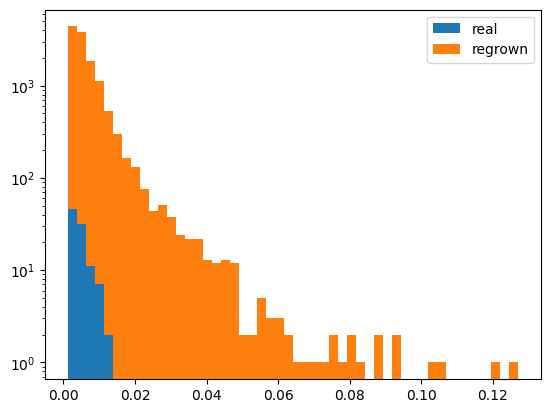

[(('preference', 'preferenceName', 'exists'), 176), (('and', 'preference', 'preferenceName'), 104), (('then', 'once', 'and'), 98), (('once', 'and', 'not'), 97), (('and', 'not', 'in_motion'), 97), (('and', 'not', 'agent_holds'), 89), (('not', 'agent_holds', 'in_motion'), 86), (('*', 'number', 'count'), 84), (('once', 'and', 'agent_holds'), 76), (('hold', 'and', 'not'), 69)]
N: 3 | Average real game score: 0.001988447185167385 | Average regrown game score: 0.008282427352345877 | Difference in means: -0.006293980167178492


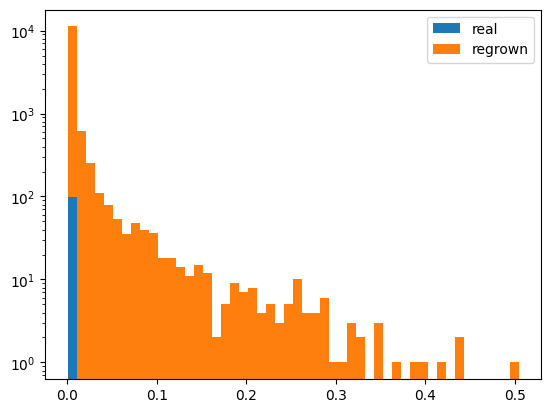

[(('and', 'preference', 'preferenceName', 'exists'), 100), (('once', 'and', 'not', 'in_motion'), 96), (('and', 'not', 'agent_holds', 'in_motion'), 85), (('then', 'once', 'and', 'agent_holds'), 76), (('hold', 'and', 'not', 'agent_holds'), 68), (('not', 'agent_holds', 'in_motion', 'once'), 63), (('and', 'in_motion', 'not', 'agent_holds'), 62), (('constraints', 'and', 'preference', 'preferenceName'), 59), (('and', 'not', 'in_motion', 'in'), 54), (('hold', 'and', 'in_motion', 'not'), 50)]
N: 4 | Average real game score: 0.0011800070977253238 | Average regrown game score: 0.011915718498611439 | Difference in means: -0.010735711400886114


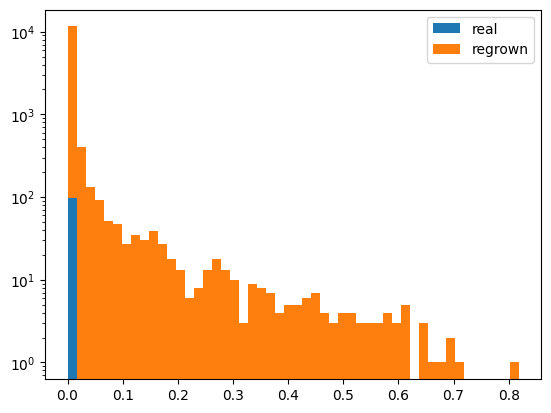

[(('hold', 'and', 'not', 'agent_holds', 'in_motion'), 68), (('and', 'not', 'agent_holds', 'in_motion', 'once'), 62), (('constraints', 'and', 'preference', 'preferenceName', 'exists'), 59), (('once', 'and', 'not', 'in_motion', 'in'), 54), (('hold', 'and', 'in_motion', 'not', 'agent_holds'), 50), (('not', 'agent_holds', 'in_motion', 'once', 'and'), 45), (('in_motion', 'once', 'and', 'not', 'in_motion'), 45), (('and', 'in_motion', 'not', 'agent_holds', 'once'), 44), (('agent_holds', 'in_motion', 'once', 'and', 'not'), 43), (('then', 'once', 'agent_holds', 'hold', 'and'), 39)]
N: 5 | Average real game score: 0.0008037451992352294 | Average regrown game score: 0.01522230759354028 | Difference in means: -0.014418562394305052


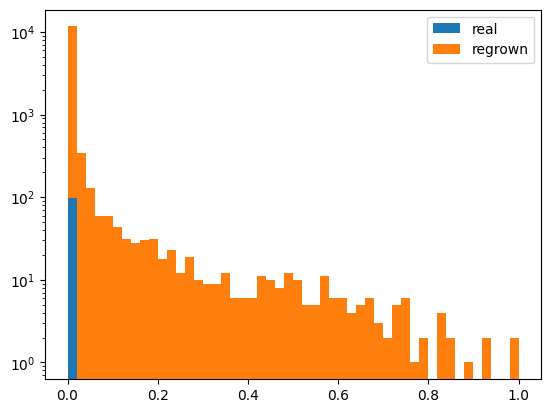

[(('hold', 'and', 'not', 'agent_holds', 'in_motion', 'once'), 62), (('and', 'not', 'agent_holds', 'in_motion', 'once', 'and'), 44), (('hold', 'and', 'in_motion', 'not', 'agent_holds', 'once'), 44), (('agent_holds', 'in_motion', 'once', 'and', 'not', 'in_motion'), 43), (('not', 'agent_holds', 'in_motion', 'once', 'and', 'not'), 41), (('agent_holds', 'hold', 'and', 'not', 'agent_holds', 'in_motion'), 35), (('then', 'once', 'agent_holds', 'hold', 'and', 'not'), 32), (('once', 'agent_holds', 'hold', 'and', 'not', 'agent_holds'), 32), (('not', 'agent_holds', 'once', 'and', 'not', 'in_motion'), 32), (('in_motion', 'not', 'agent_holds', 'once', 'and', 'not'), 31)]
N: 6 | Average real game score: 0.000601644810814688 | Average regrown game score: 0.01912437057197032 | Difference in means: -0.018522725761155632


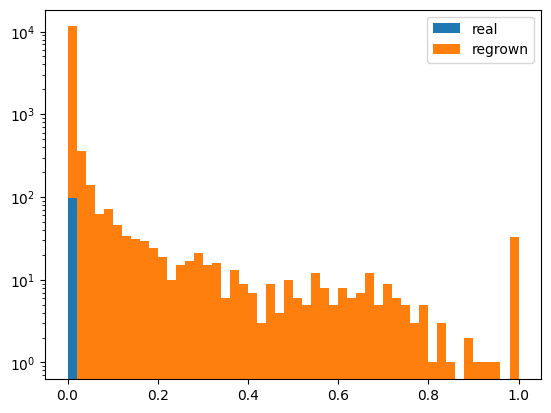

In [17]:
for n in range(2, 7):
    
    model = NGramModel(n)
    model.fit(real_game_texts)

    top_ngrams = sorted(model.ngram_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    print(top_ngrams)

    real_game_scores = model.transform(real_game_texts)
    regrown_game_scores = model.transform(regrown_game_texts)
    print(f'N: {n} | Average real game score: {np.mean(real_game_scores)} | Average regrown game score: {np.mean(regrown_game_scores)} | Difference in means: {np.mean(real_game_scores) - np.mean(regrown_game_scores)}')

    cm = plt.get_cmap('tab10')
    plt.hist([real_game_scores, regrown_game_scores], bins=50, stacked=True, label=['real', 'regrown'], color=[cm(0), cm(1)])
    plt.semilogy()
    plt.legend()
    plt.show()

In [ ]:
real_game_ngram_counts = compute_ngram_counts(real_game_texts, 5)
total_ngram_counts = sum(real_game_ngram_counts.values())
real_game_ngram_probs = defaultdict(float, {ngram: count / total_ngram_counts for ngram, count in real_game_ngram_counts.items()})

In [ ]:
regrown_game_ngram_probs = compute_ngram_counts(regrown_game_texts, 5)
total_regrown_ngram_counts = sum(regrown_game_ngram_probs.values())
regrown_game_ngram_probs = {ngram: count / total_regrown_ngram_counts for ngram, count in regrown_game_ngram_probs.items()}

In [ ]:
n_gram_prob_differences = real_game_ngram_probs.copy()
for ngram, prob in regrown_game_ngram_probs.items():
    n_gram_prob_differences[ngram] -= prob

max_difference_ngrams = sorted(n_gram_prob_differences.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
max_difference_ngrams

In [ ]:
min_difference_ngrams = sorted(n_gram_prob_differences.items(), key=lambda x: abs(x[1]))[:20]
min_difference_ngrams

In [40]:
from fitness_ngram_models import ASTMultiNGramModel

In [41]:
ast_ngram_model = ASTMultiNGramModel([2, 3, 4, 5])
ast_ngram_model.fit(game_asts)
